## Notebook for semantic segmentation of land cover
- Use (12.5cm currently) aerial images (3 bands)
- Use raster masks with class labels
- Use U-net (like) CNN to perform semantic segmentation. 

Thoughts:
- Handle no-class? (class = 0). Could fix in data by interpolating - although that takes some time.. Can we somehow set the cost to 0 of these pixels? Don't want to ruin the conv filters. 
- Possibly change class labels here. (Eg wood vs grass vs other). Probably best to do here when loading raster masks, instead of creating masks like this directly (as they take up considerable disk space and there might be many version. Should be quick to do.)

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision, torchsummary
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

### Split image into patches:
- Full image tiles (1km^2, in 12.5cm resolution) are quite large to handle. Also generally models take input sizes as a multiple of 2.
- Therefore, split tiles into patches of new (smaller) size.

In [3]:
## From image & mask directories, create patches with given patch_size. 
## NB: images are cropped so remaining pixels are discarded at the moment. To be fixed (by merging adjacent tiles).
all_patches_img, all_patches_mask = lca.create_all_patches_from_dir(patch_size=512)

## Next, the labels are typically non-consecutive (eg [0, 1, 2, 5, 6, 9, 11]) because classes
## are missing. It's best to map labels to a new consecutive scheme to prevent issues further ahead:
all_patches_mask, (unique_labels_array, mapping_label_to_new_dict, class_name_list) = lca.change_labels_to_consecutive_numbers(mask_patches=all_patches_mask)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


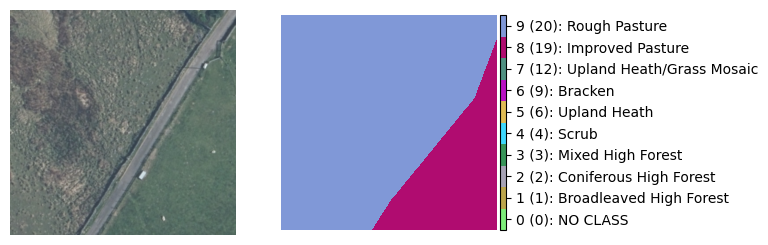

In [4]:
## Plot example patch (image + mask):

fig, ax = plt.subplots(1, 2)
i_p = 0  # index of patch. Left to righ, top to bottom 
lcv.plot_image_simple(im=all_patches_img[i_p, :, :, :], ax=ax[0])

lcv.plot_landcover_image(all_patches_mask[i_p, :, :], ax=ax[1],
                        lc_class_name_list=class_name_list,
                        unique_labels_array=unique_labels_array)


### Create train/test split of the data
- Random split for now. 
- Later look into way to split classes evenly across train and test set. 
- Also add validation set later

In [5]:
im_train, im_test, mask_train, mask_test = lca.split_patches_in_train_test(all_patches_img=all_patches_img, all_patches_mask=all_patches_mask)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


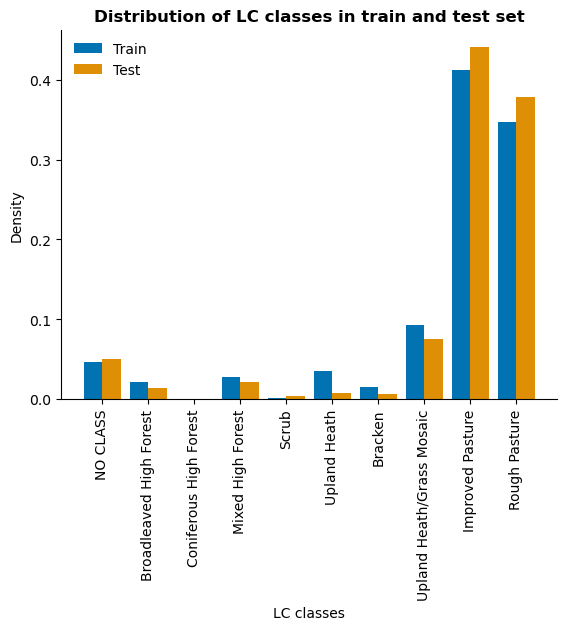

In [6]:
## Plot distribution of classes in train & test set:
_, __, (inds_classes, names_classes, n_classes) = lcv.plot_comparison_class_balance_train_test(train_patches_mask=mask_train, test_patches_mask=mask_test,
                                                                                             names_classes=class_name_list)

In [7]:
## Change from np array to torch tensor:
mask_train, mask_test = lca.change_data_to_tensor(mask_train, mask_test, tensor_dtype='int')
im_train, im_test = lca.change_data_to_tensor(im_train, im_test, tensor_dtype='float')

#### Prep
- See if GPU works:

In [8]:
lca.check_torch_ready(check_gpu=True, assert_versions=True)

Pytorch version is 1.12.1+cu102
Torchvision version is 0.13.1+cu102
Segmentation-models-pytorch version is 0.3.0


### Define model:

In [9]:
# n_classes = len(unique_labels_array)  # n_classes is returned from the class distribution plot above, but can otherwise be obtained like this.
LCU = lcm.LandCoverUNet(n_classes=n_classes, lr=1e-3)  # load model 

## Plot summary of layers:
# torchsummary.summary(LCU, input_size=np.shape(np.squeeze(im_test[0, :, :, :])), device='cpu')## Use tensorboard to monitor performance

In [10]:
## Images should be preprocessed as expected by the model, which is essentially a z-score (at this point)
preprocessing_func = LCU.preprocessing_func  # extract preprocessing function

im_train = lca.apply_zscore_preprocess_images(im_ds=im_train, f_preprocess=preprocessing_func, verbose=1)
im_test = lca.apply_zscore_preprocess_images(im_ds=im_test, f_preprocess=preprocessing_func, verbose=1)

## Create torch DataLoaders for train & test:
train_dl, test_dl = lca.create_data_loaders(x_train=im_train, x_test=im_test, y_train=mask_train, y_test=mask_test, 
                                            batch_size=10)  # batch size can be experimented with. 10 (with 512x512 images) seems around the limit of my GPU's memory

Changing range
Z scoring data
Changing range
Z scoring data


In [11]:
## The LCU model is written using PL API. Therefore use PL trainer to conduct training & evaluation of model:
trainer = pl.Trainer(max_epochs=150, accelerator='gpu', devices=1)  # run on GPU; and set max_epochs.
trainer.fit(model=LCU, train_dataloaders=train_dl)  # could include validation set here to determine convergence


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:109: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | base | Unet             | 32.5 M
1 | loss | CrossEntropyLoss | 0     
------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.090   Total estimated model params size (MB)
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck.

Training: 0it [00:00, ?it/s]

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
`Trainer.fit` stopped: `max_epochs=150` reached.


In [ ]:
## Use tensorboard to monitor performance
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

## Or in terminal (in same conda env):
## tensorboard --logdir ~/repos/cnn-landcover/lightning_logs/

In [12]:
## test the model performance on test data set
trainer.test(LCU, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6738777160644531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.6738777160644531}]

In [13]:
## Predict the labels of unseen data => use test data for now so we can compare performance to (LC 80s) 'ground truth'
pred_test = trainer.predict(LCU, test_dl)  # returns list of tensors (one tensor for each batch)
pred_test = lca.concat_list_of_batches(pred_test)  # concatenate batches
## LCU outputs a softmax (ie 1 probability for each class) => get argmax for visual comparison
pred_test = lca.change_tensor_to_max_class_prediction(pred=pred_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 108it [00:00, ?it/s]

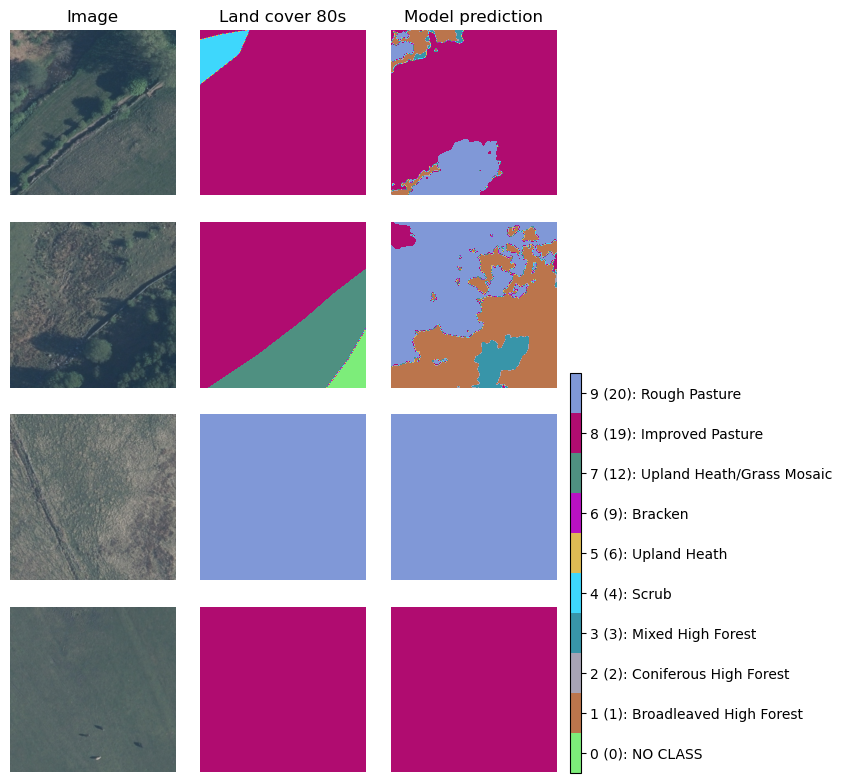

In [65]:
## Plot image + LC 80s ground truth + prediction
index_first_image = 84
n_images = 4
ind_list_show = [index_first_image + x for x in range(n_images)]
## 35, 57, 75

# ind_list_show = [35, 75, 82, 97, 99, 107]

lcv.plot_image_mask_pred_from_all(all_ims=im_test, all_masks=mask_test, all_preds=pred_test,
                                  preprocessing_fun=LCU.preprocessing_func, 
                                  ind_list=ind_list_show,
                                  lc_class_name_list=class_name_list, unique_labels_array=unique_labels_array,
                                  save_fig=True, filename_prefix='LC_predictions_150epochs')

In [70]:
## Plot image + LC 80s ground truth + prediction
for index_first_image in tqdm(range(0, 266, 4)):
    n_images = 4
    ind_list_show = [index_first_image + x for x in range(n_images)]
    ## 35, 57, 75

    # ind_list_show = [35, 75, 82, 97, 99, 107]

    lcv.plot_image_mask_pred_from_all(all_ims=im_test, all_masks=mask_test, all_preds=pred_test,
                                    preprocessing_fun=LCU.preprocessing_func, 
                                    ind_list=ind_list_show,
                                    lc_class_name_list=class_name_list, unique_labels_array=unique_labels_array,
                                    save_fig=True, filename_prefix='LC_predictions_150epochs')
    plt.close()

100%|██████████| 67/67 [00:53<00:00,  1.25it/s]


In [ ]:
# ## From https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html#save-a-checkpoint

# ## LightningModule from checkpoint
# ## To load a LightningModule along with its weights and hyperparameters use the following method:

# model = LCU.load_from_checkpoint("/path/to/checkpoint.ckpt")

# # disable randomness, dropout, etc...
# model.eval()

# # predict with the model
# y_hat = model(x)

In [59]:
LCU_150 = LCU.load_from_checkpoint('lightning_logs/version_12/checkpoints/epoch=149-step=16200.ckpt')

In [60]:
## Predict the labels of unseen data => use test data for now so we can compare performance to (LC 80s) 'ground truth'
pred_test_150 = trainer.predict(LCU_150, test_dl)  # returns list of tensors (one tensor for each batch)
pred_test_150 = lca.concat_list_of_batches(pred_test_150)  # concatenate batches
## LCU outputs a softmax (ie 1 probability for each class) => get argmax for visual comparison
pred_test_150 = lca.change_tensor_to_max_class_prediction(pred=pred_test_150)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 108it [00:00, ?it/s]

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
